# Introduction
- Compare npj results to schrodingers
    - Is the discrepancy due to choice of:
        - Functional?
        - ML-architecture?
- Sam's paper seems to suggest that:
    - MACE is more efficient in terms of data set size requirements,
    - it is possible to generate data with one ML-architecture and train a model with a different ML-architecture on that data and expect similar results, and
    - produces more reliable diffusivities and densities with low seed variability for bulk-models
- Is it possible to train MACE on clusters?
    - This would perhaps allow one to use hybrid functionals
    - We note that the Schrodiger publication had long-range interactions and a different goal than we have here, but we want to see how well it works anyway
    - We should provide examples of studies that focused on neutral systems without excplicit long-range electrostatics with a reasonable degree of success to motivate this further. Just to say something.

# Results and discussion 

In [111]:
import matplotlib.pyplot as plt

dynamics_path = '../publication/dynamics/'

tmap = {
    'npt_000conEC_298K':'EMC',
    'npt_033conEC_298K':'EC:EMC (3:7)',
    'npt_066conEC_298K':'EC:EMC (7:3)',
    'npt_100conEC_313K':'EC',
}

In [112]:
def get_all_thermo(tag):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    thermo = {}
    flist = [name for name in glob.glob(tag)]
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

## Cluster v. Bulk
We recompute one bulk- and one cluster data set sampled from the full Schrodinger data with B97-D3BJ. We then train two models on each, run dynamics, and compare their results.
### Force correlations and radial distribution
We expect this to look good

### Densities and diffusivites
We see that this comparison looks good

IBM23/B97/SEED1/DSET1
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
SDN22NQ/B97/SEED1/DSET1
dict_keys(['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])


/tmp/ipykernel_408093/4247371354.py:34: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



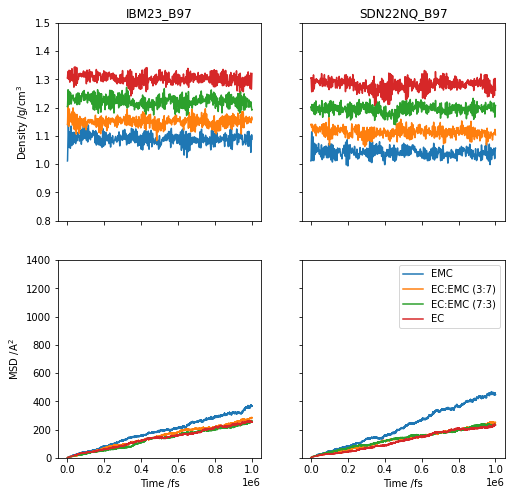

In [113]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    print(tag)
    print(thermo[k].keys())
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name])

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[1,1].legend(loc='upper right')

### Data set size optimisation
This is where we show how it all falls apart

### Seed and data set variability

## Possible sources of error
Here we start by doing some data analysis and to look for different correlations between properties etc.

# Other questions and remarks
- Vscans for clusters, bulk and compared to DFT
    - Poor results: shows that this test is not rigorous
    - Good results: shows that this test is perhaps not a good test
- Force-correlations between models
    - Take the trajectories of each models (cluster v. bulk comparison), select a set of snapshot and recompute with B97 and do, for each model, force correlations compared with DFT reference
    - Correlate the two models, independent of DFT reference. Do a triangle-inequality check in force RMSE. Does it say anything?
- IMPORTANT: The schrodinger people systematically sampled structures that were strained or otherwise high in energy in order to have agreement across their QEq-committe. Since this is not of interest to us, it might just be that these structures are inappropriate to train a short-range model on. A different selection might have worked better!
- Check local environments. Take a model independent of any here, such as the MP0 model. Use it to generate fingerprints for the training sets (bulk and cluster) and to t-SNE test to see if they mix or not